<a href="https://colab.research.google.com/github/BOUBEGHELRima/Anomaly_detection/blob/main/load_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

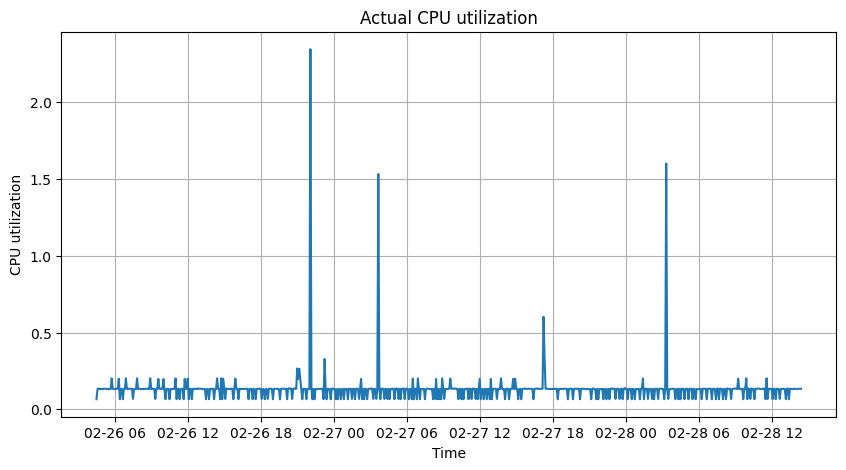

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

dataset = pd.read_csv('/content/ec2_cpu_utilization_24ae8d.csv')
column_name = 'value'


# Select the last 532 rows of the dataset
last_rows = dataset.tail(696)


data = last_rows[['timestamp', column_name]]

# Convert the Time column to datetime if it's not already
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# Fill missing values
data[column_name].fillna(method='ffill', inplace=True)


# Plot the selected data
plt.figure(figsize=(10, 5))
plt.plot(data.index, data[column_name])
plt.title('Actual CPU utilization')
plt.xlabel('Time')
plt.ylabel('CPU utilization')
plt.grid(True)
plt.show()

In [29]:
data

,value
timestamp,
2014-02-26 04:30:00,0.066
2014-02-26 04:35:00,0.132
2014-02-26 04:40:00,0.136
2014-02-26 04:45:00,0.132
2014-02-26 04:50:00,0.132
...,...
2014-02-28 14:05:00,0.132
2014-02-28 14:10:00,0.134
2014-02-28 14:15:00,0.134


22/22 [==============================] - 1s 3ms/step


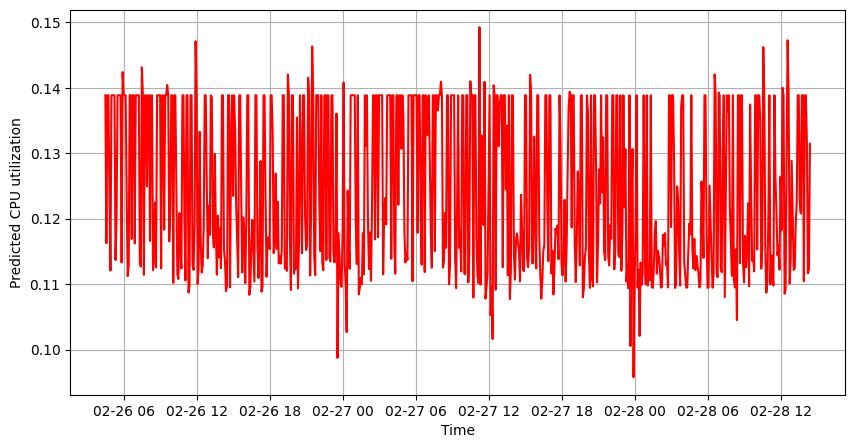

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import joblib  # Assuming you have saved the scaler previously

# Assuming 'data' is your DataFrame containing the dataset
Time = data.index

# Load the model from the HDF5 format
loaded_model = load_model('/content/best_model.h5')

# Load the test data
x = np.load('/content/test.npy')
x = x[-696:]  # Select the last 532 rows of the data

# Ensure x is shaped correctly for prediction
# Adjust depending on your specific model's input requirements
if len(x.shape) == 1:
    x = x.reshape(1, -1, 1)

# Make predictions
Predict = loaded_model.predict(x)


# Create an array to store forecast values for plotting
forecastPlot = np.empty((len(Predict),))  # No need to add extra steps for future time steps
forecastPlot[:] = np.nan
forecastPlot[:] = Predict.flatten()  # Assuming Predict is 2D and the predictions are at the end

# Plotting the predictions
plt.figure(figsize=(10, 5))
plt.plot(Time[-len(Predict):], Predict, color='red')  # Use Time[-len(Predict):] to match the length of Predict
plt.xlabel('Time')
plt.ylabel('Predicted CPU utilization')  # Replace with the actual column name
plt.grid(True)
plt.show()



In [31]:
y_true=data[column_name].values
predictions=Predict
len(predictions)

696

In [32]:
len(y_true)

696

In [33]:
import numpy as np
import pandas as pd

# Ensure y_true and predictions are flattened correctly
y_true = y_true.flatten()
predictions = predictions.flatten()

# Calculate the prediction error
error = np.abs(y_true - predictions)

# Define a threshold for anomaly detection
threshold = np.mean(error) + 3 * np.std(error)

# Identify anomalies
anomalies = error > threshold

# Ensure SEQ_LENGTH is set correctly
total_length = len(data)
desired_length = 696
SEQ_LENGTH = total_length - desired_length

# Check the lengths to debug
print(f"Length of data index[SEQ_LENGTH:]: {len(data.index[SEQ_LENGTH:])}")
print(f"Length of anomalies: {len(anomalies)}")

# Get the timestamps of anomalies
anomaly_timestamps = data.index[SEQ_LENGTH:][anomalies]

# Create a dataframe for anomalies
anomalies_df = pd.DataFrame({
    'timestamp': anomaly_timestamps,
    'actual': y_true[anomalies],
    'predicted': predictions[anomalies]
})

# Display the anomalies DataFrame
print(anomalies_df)


Length of data index[SEQ_LENGTH:]: 696
Length of anomalies: 696
            timestamp  actual  predicted
0 2014-02-26 22:05:00   2.344   0.123050
1 2014-02-27 03:40:00   1.532   0.138850
2 2014-02-27 17:15:00   0.602   0.115106
3 2014-02-28 03:20:00   1.600   0.109411


In [34]:
anomaly_timestamps

DatetimeIndex(['2014-02-26 22:05:00', '2014-02-27 03:40:00',
               '2014-02-27 17:15:00', '2014-02-28 03:20:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

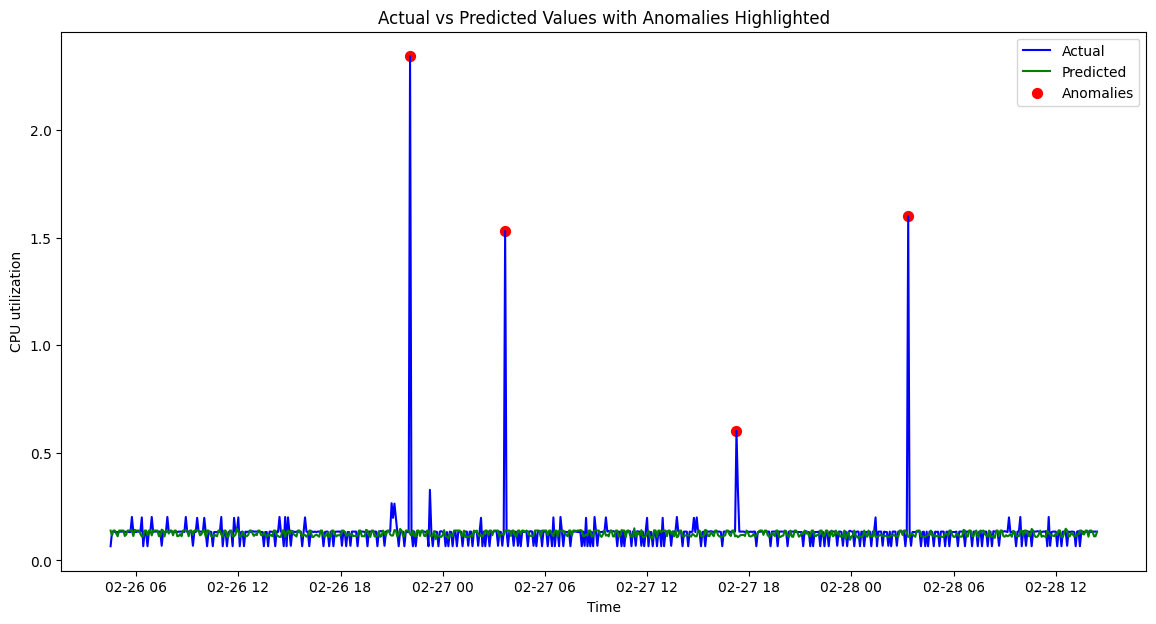

In [35]:
# Plot the actual values, predicted values, and highlight the anomalies
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(Time, y_true, label='Actual', color='blue')

# Plot predicted values
plt.plot(Time, predictions, label='Predicted', color='green')

# Highlight anomalies
plt.scatter(anomalies_df['timestamp'], anomalies_df['actual'], color='red', label='Anomalies', s=50)

plt.xlabel('Time')
plt.ylabel('CPU utilization')
plt.title('Actual vs Predicted Values with Anomalies Highlighted')
plt.legend()
plt.show()

In [36]:
anomalies_df

,timestamp,actual,predicted
0,2014-02-26 22:05:00,2.344,0.123050
1,2014-02-27 03:40:00,1.532,0.138850
2,2014-02-27 17:15:00,0.602,0.115106
3,2014-02-28 03:20:00,1.600,0.109411
